Null values in each column:
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64
Percentage of defaulters: 8.07%
Percentage of non-defaulters: 91.93%


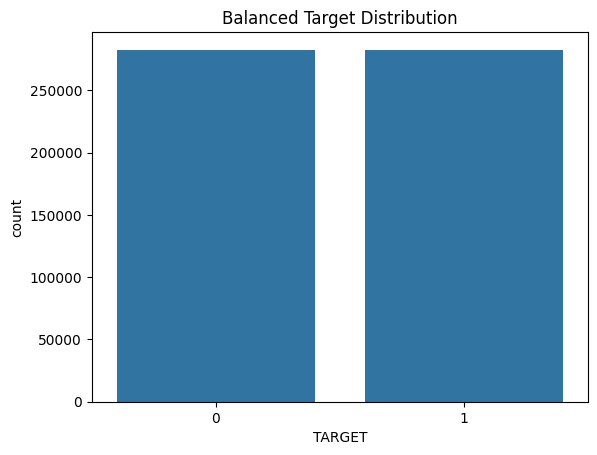

C:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 177s 15ms/step - accuracy: 0.6713 - loss: 0.6069 - val_accuracy: 0.6955 - val_loss: 0.5778
Epoch 2/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 158s 14ms/step - accuracy: 0.7052 - loss: 0.5656 - val_accuracy: 0.7172 - val_loss: 0.5472
Epoch 3/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 159s 14ms/step - accuracy: 0.7350 - loss: 0.5253 - val_accuracy: 0.7361 - val_loss: 0.5252
Epoch 4/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 173s 15ms/step - accuracy: 0.7613 - loss: 0.4868 - val_accuracy: 0.7569 - val_loss: 0.4946
Epoch 5/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 144s 13ms/step - accuracy: 0.7830 - loss: 0.4561 - val_accuracy: 0.7735 - val_loss: 0.4749
Epoch 6/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 169s 10ms/step - accuracy: 0.7961 - loss: 0.4339 - val_accuracy: 0.7799 - val_loss: 0.4668
Epoch 7/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step - accuracy: 0.8077 - loss: 0.4153 - val_accuracy: 0.7868 - val_loss: 0.4586
Epoch 8/10
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 96s 8ms/step 

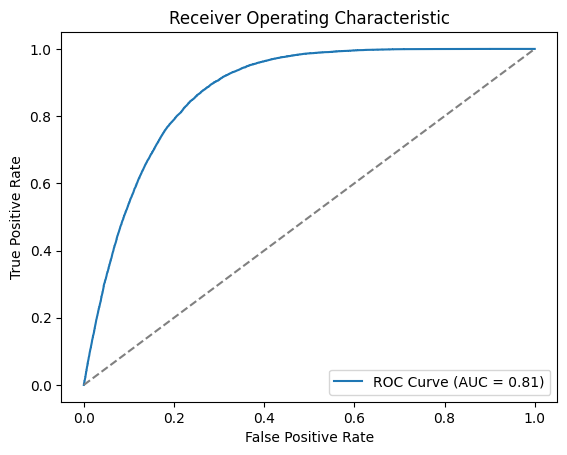

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 1: Load the dataset
df = pd.read_csv('C:/Users/shrey/Downloads/dataset/House Loan Data Analysis_Dataset/loan_data.csv')

# Step 2: Check for null values
print("Null values in each column:")
print(df.isnull().sum())

# Fill missing values only for numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())


# Step 3: Analyze the target column
target_dist = df['TARGET'].value_counts(normalize=True) * 100
print(f"Percentage of defaulters: {target_dist[1]:.2f}%")
print(f"Percentage of non-defaulters: {target_dist[0]:.2f}%")

# Step 4: Handle imbalanced data
# Separate majority and minority classes
df_majority = df[df.TARGET == 0]
df_minority = df[df.TARGET == 1]

# Oversample the minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples=len(df_majority), 
                                 random_state=42)

# Combine the majority and upsampled minority classes
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Step 5: Visualize the balanced data
sns.countplot(x='TARGET', data=df_balanced)
plt.title('Balanced Target Distribution')
plt.show()

# Step 6: Encode categorical variables
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                       'NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 
                       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
                       'NAME_HOUSING_TYPE']
df_encoded = pd.get_dummies(df_balanced, columns=categorical_columns, drop_first=True)

# Separate features and target variable
X = df_encoded.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_encoded['TARGET']

# Step 7: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Define preprocessing for numeric and categorical data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing numeric values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



# Build the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Step 8: Evaluate sensitivity
y_pred = (model.predict(X_test) > 0.5).astype(int)
sensitivity = recall_score(y_test, y_pred)
print(f"Sensitivity: {sensitivity:.2f}")

# Step 9: Calculate and plot ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
